In [1]:
# --- Imports Fundamentales ---
import joblib
import json
import glob
import re
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# --- Estilo de Figuras para Publicación (Estilo Nature/Cell) ---
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300
})
sns.set_style("whitegrid")
warnings.filterwarnings('ignore', category=UserWarning)

# --- Rutas del NUEVO Experimento ---
RESULTS_DIR = Path("./resultados31") # <-- ¡ÚNICO LUGAR PARA CAMBIAR LA RUTA!
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# --- Detección y Carga Automática de Archivos ---
try:
    # Usa glob para encontrar el archivo CSV, ya que el nombre es largo
    csv_path_list = glob.glob(str(RESULTS_DIR / "all_folds_metrics_MULTI_*.csv"))
    if not csv_path_list:
        raise FileNotFoundError("No se encontró el archivo CSV de métricas.")
    CSV_PATH = csv_path_list[0]
    
    # Extrae el sufijo único del nombre del archivo para encontrar los demás
    match = re.search(r"MULTI_(.+)\.csv", CSV_PATH)
    if not match:
        raise ValueError("No se pudo extraer el sufijo del nombre del archivo CSV.")
    SUFFIX = match.group(1)
    
    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    PRED_PATH = RESULTS_DIR / f"all_folds_clf_predictions_MULTI_{SUFFIX}.joblib"
    
    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")

    # Carga de Datos
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    predictions = joblib.load(PRED_PATH)
    
    # Determinar el mejor clasificador basado en la métrica objetivo
    scoring_metric = metrics_df.columns[metrics_df.columns.str.contains("auc_bal", case=False)][0]
    best_clf_name = metrics_df.groupby('classifier')[scoring_metric].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en '{scoring_metric}')")

except (FileNotFoundError, ValueError, IndexError) as e:
    print(f"❌ ERROR: {e}\n   Asegúrate de que la ruta '{RESULTS_DIR}' es correcta y el pipeline ha finalizado.")
    metrics_df, histories, predictions, best_clf_name = None, None, None, None

✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld256_beta1.0_normzscore_offdiag_ch4sel_intFChalf_drop0.25_ln1_outer5x1_scoreauc_bal07
🏆 Mejor clasificador identificado: 'gb' (basado en 'auc_bal07')


In [2]:
if metrics_df is not None:
    # Diccionario para renombrar métricas a un formato más legible
    key_metrics = {
        scoring_metric: 'Score Compuesto (AUC*0.7 + Bal.Acc*0.3)',
        'auc': 'AUC-ROC',
        'bal_acc_def': 'Balanced Accuracy',
        'sens_def': 'Sensibilidad (Recall)',
        'spec_def': 'Especificidad',
        'pr_auc': 'AUC-PR'
    }
    
    # Filtrar por el mejor clasificador y las métricas clave
    df_summary = metrics_df[metrics_df['classifier'] == best_clf_name][list(key_metrics.keys())]
    
    # Calcular media y desviación estándar
    summary_stats = df_summary.agg(['mean', 'std']).T
    summary_stats.index = summary_stats.index.map(key_metrics)
    summary_stats['Rendimiento (Media ± DE)'] = summary_stats.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)
    
    table1 = summary_stats[['Rendimiento (Media ± DE)']]
    table1.index.name = 'Métrica de Evaluación'
    
    print(f"\n--- Tabla 1: Rendimiento del Modelo Óptimo ({best_clf_name.upper()}) ---")
    display(table1)
    
    # Guardar en formato LaTeX para el paper
    latex_path = OUTPUT_FIG_DIR / "table1_performance_summary.tex"
    table1.to_latex(latex_path, column_format="lc")
    print(f"📄 Tabla guardada en: {latex_path}")


--- Tabla 1: Rendimiento del Modelo Óptimo (GB) ---


,Rendimiento (Media ± DE)
Métrica de Evaluación,
Score Compuesto (AUC*0.7 + Bal.Acc*0.3),0.795 ± 0.065
AUC-ROC,0.829 ± 0.066
Balanced Accuracy,0.715 ± 0.068
Sensibilidad (Recall),0.642 ± 0.078
Especificidad,0.787 ± 0.106
AUC-PR,0.877 ± 0.044


📄 Tabla guardada en: resultados31/publication_figures/table1_performance_summary.tex


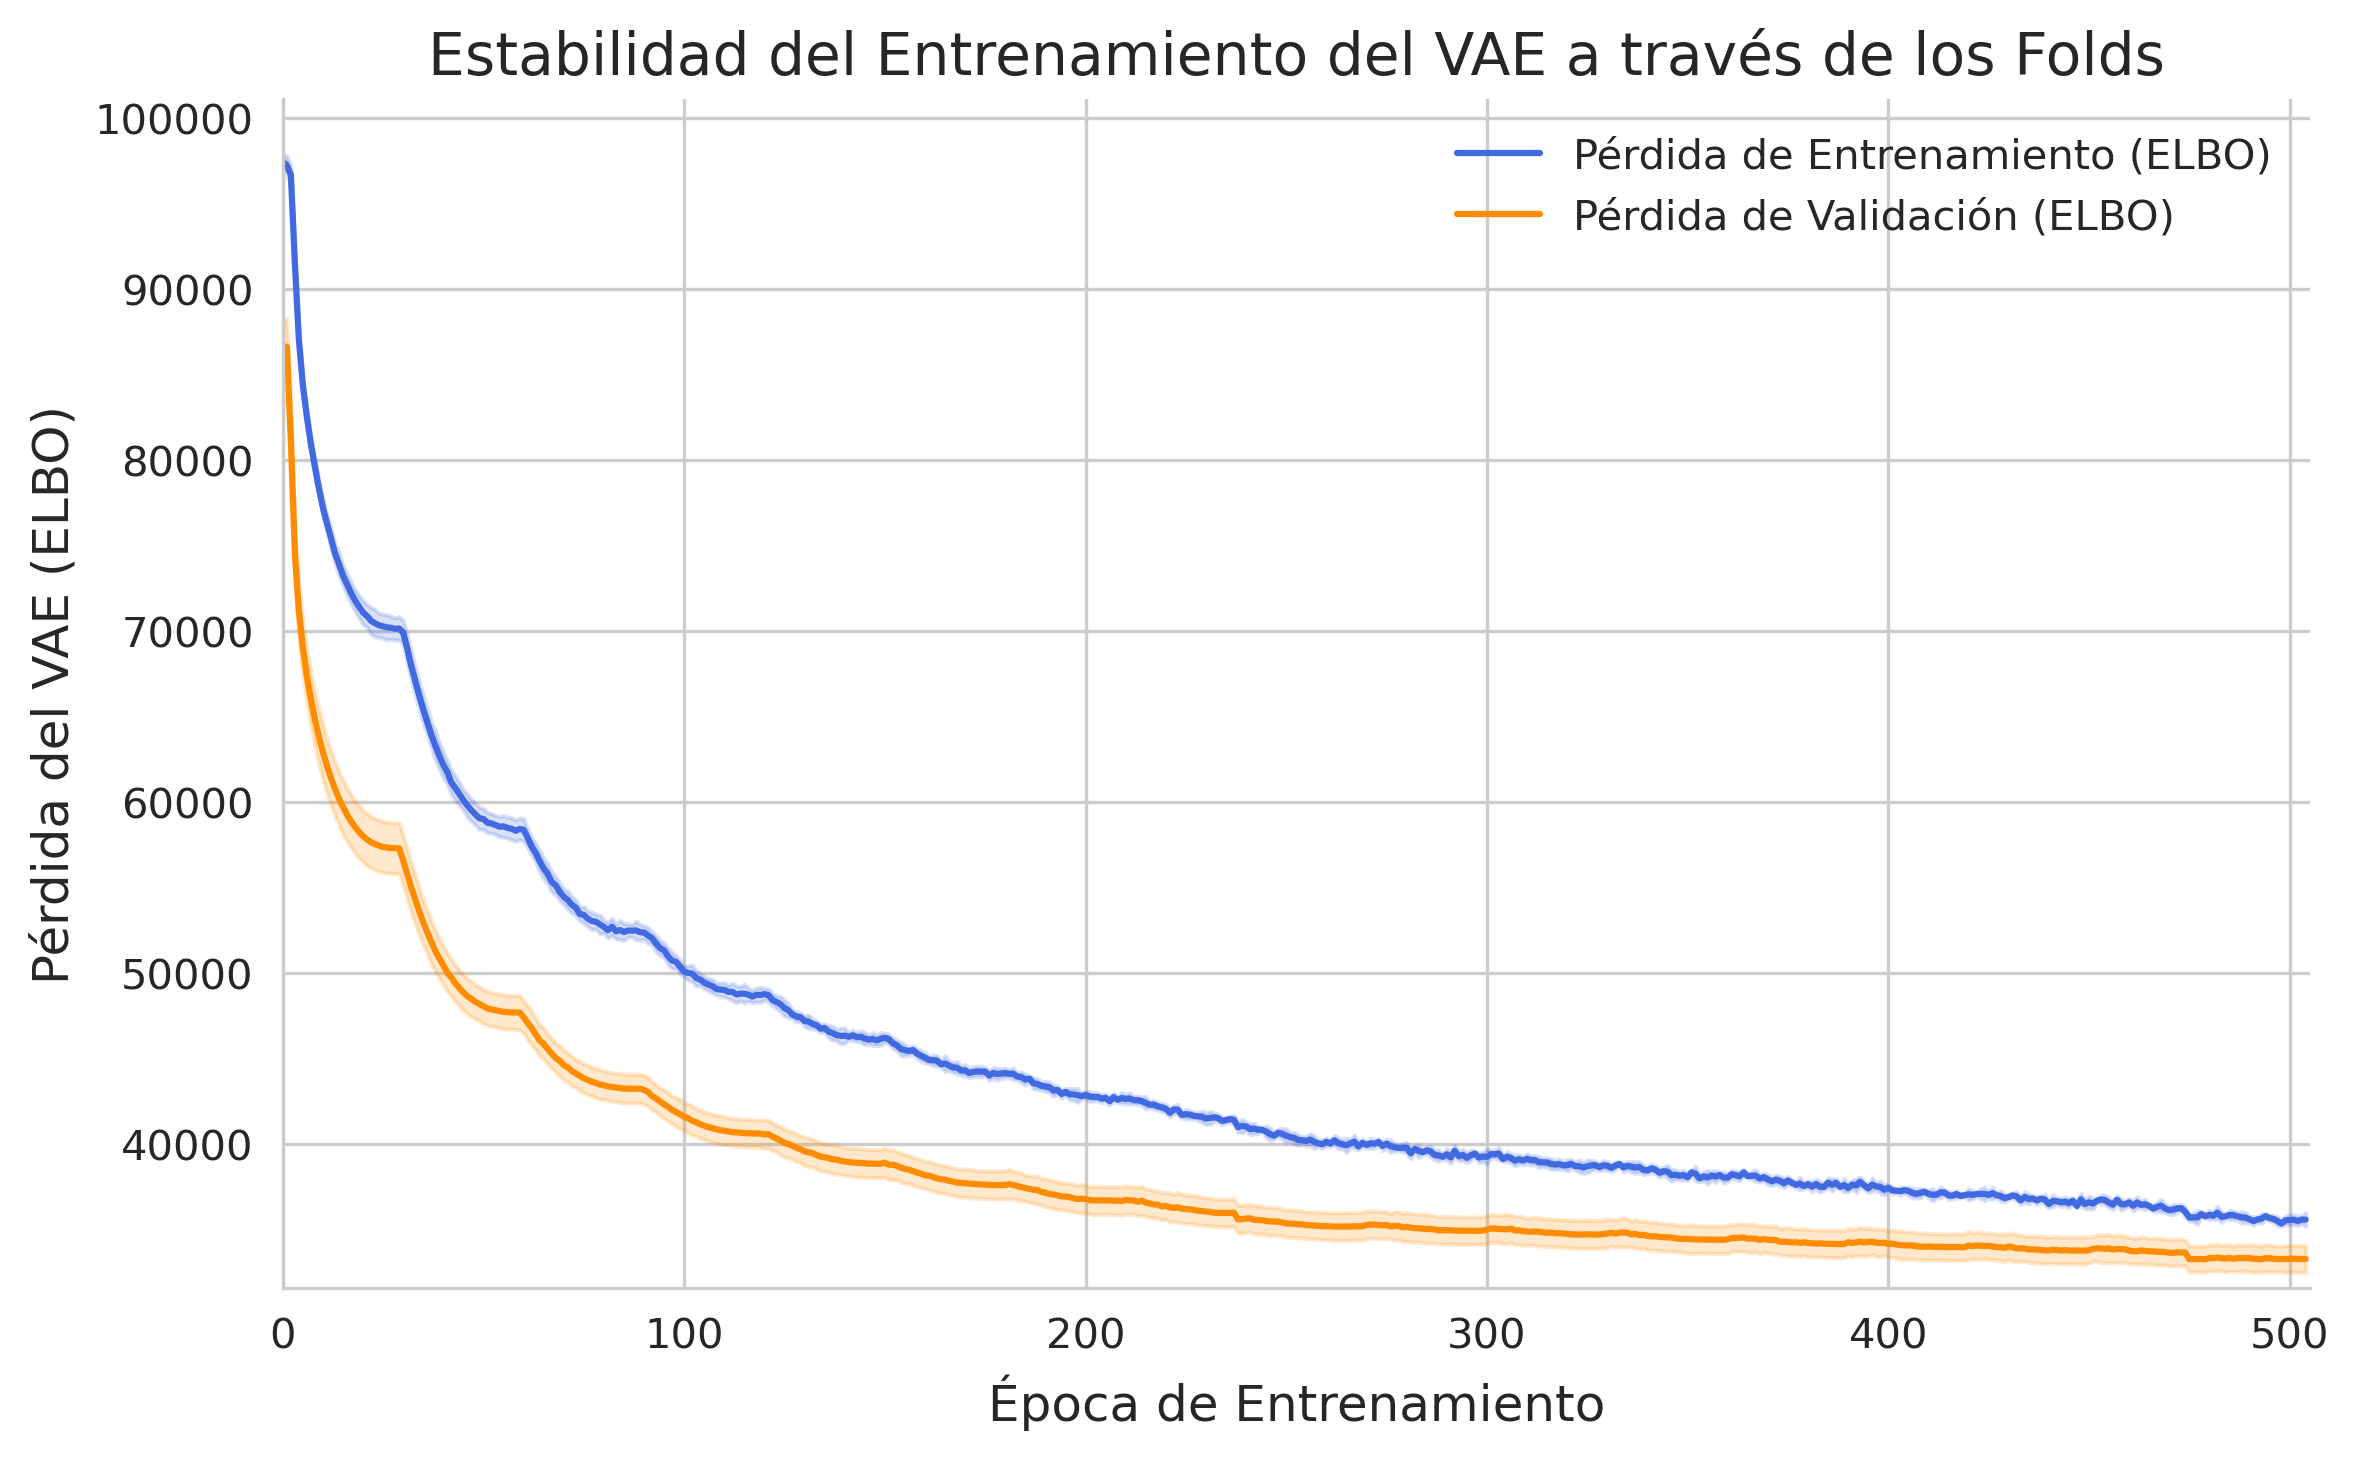

📄 Figura guardada en: resultados31/publication_figures/fig1_vae_training_curves.pdf


In [3]:
if histories is not None:
    # Truncar historiales a la longitud mínima para un promediado robusto
    min_len = min(len(h['train_loss']) for h in histories if h)
    
    # Recolectar datos de todos los folds
    train_loss = np.array([h['train_loss'][:min_len] for h in histories if h])
    val_loss = np.array([h['val_loss'][:min_len] for h in histories if h])
    
    mean_train, std_train = train_loss.mean(axis=0), train_loss.std(axis=0)
    mean_val, std_val = val_loss.mean(axis=0), val_loss.std(axis=0)
    
    epochs = np.arange(min_len)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(epochs, mean_train, color='royalblue', label='Pérdida de Entrenamiento (ELBO)')
    ax.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='royalblue', alpha=0.2)
    
    ax.plot(epochs, mean_val, color='darkorange', label='Pérdida de Validación (ELBO)')
    ax.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='darkorange', alpha=0.2)
    
    ax.set_xlabel("Época de Entrenamiento")
    ax.set_ylabel("Pérdida del VAE (ELBO)")
    ax.set_title("Estabilidad del Entrenamiento del VAE a través de los Folds")
    ax.legend(frameon=False)
    ax.set_xlim(0, min_len)
    ax.set_ylim(bottom=min(mean_val.min(), mean_train.min()) * 0.95) # Ajuste dinámico del eje Y
    sns.despine(ax=ax)
    
    plt.tight_layout()
    fig_path = OUTPUT_FIG_DIR / "fig1_vae_training_curves.pdf"
    fig.savefig(fig_path, dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {fig_path}")

/tmp/ipykernel_260967/2157130598.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


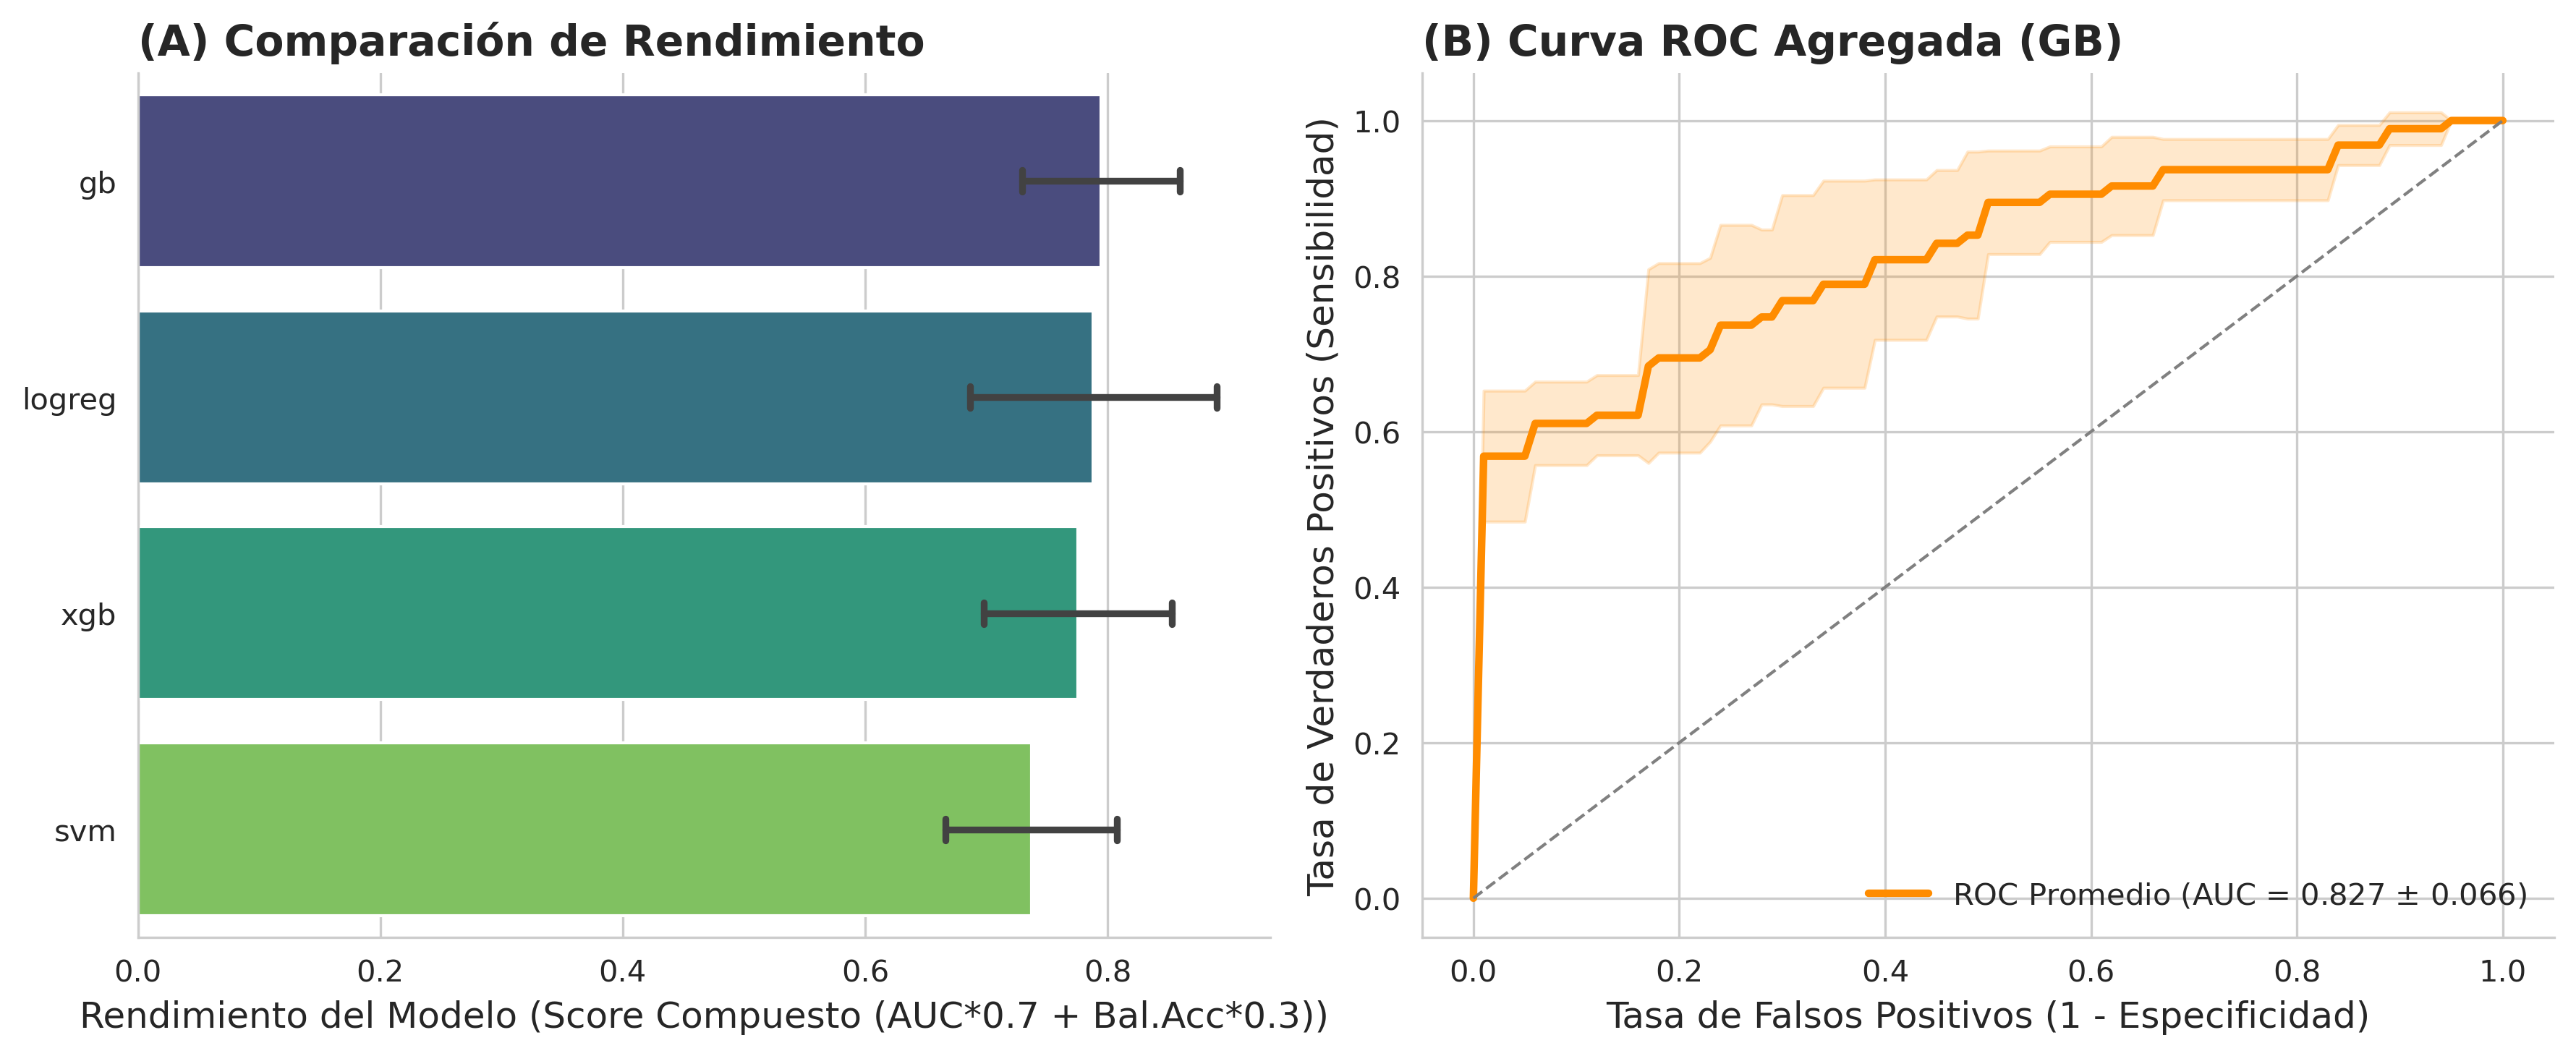

📄 Figura guardada en: resultados31/publication_figures/fig2_classifier_performance.pdf


In [4]:
if metrics_df is not None:
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)

    # --- Panel A: Comparación de AUC ---
    ax1 = fig.add_subplot(gs[0, 0])
    order = metrics_df.groupby('classifier')[scoring_metric].mean().sort_values(ascending=False).index
    
    sns.barplot(
        data=metrics_df, y='classifier', x=scoring_metric,
        order=order, palette='viridis', ax=ax1,
        errorbar='sd', capsize=0.1
    )
    ax1.set_xlabel(f"Rendimiento del Modelo ({key_metrics[scoring_metric]})")
    ax1.set_ylabel("")
    ax1.set_title("(A) Comparación de Rendimiento", loc='left', weight='bold')
    sns.despine(ax=ax1)

    # --- Panel B: Curva ROC Agregada del Mejor Modelo ---
    ax2 = fig.add_subplot(gs[0, 1])
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    best_clf_preds = [p for p in predictions if p['classifier'] == best_clf_name]
    
    for pred in best_clf_preds:
        fpr, tpr, _ = roc_curve(pred['y_test'], pred['proba_test'])
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    mean_auc = auc(base_fpr, mean_tprs)
    auc_std = metrics_df[metrics_df["classifier"] == best_clf_name]["auc"].std()
    
    ax2.plot(base_fpr, mean_tprs, color='darkorange', lw=2.5, label=f'ROC Promedio (AUC = {mean_auc:.3f} $\\pm$ {auc_std:.3f})')
    ax2.fill_between(base_fpr, mean_tprs - std_tprs, mean_tprs + std_tprs, color='darkorange', alpha=0.2)
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    
    ax2.set_xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
    ax2.set_ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
    ax2.set_title(f"(B) Curva ROC Agregada ({best_clf_name.upper()})", loc='left', weight='bold')
    ax2.legend(loc='lower right', frameon=False)
    sns.despine(ax=ax2)

    plt.tight_layout()
    fig_path = OUTPUT_FIG_DIR / "fig2_classifier_performance.pdf"
    fig.savefig(fig_path, dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {fig_path}")

In [5]:
import umap.umap_ as umap
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde

def umap_embedding(latent, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=42):
    """Ejecuta UMAP sobre los datos latentes."""
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    return reducer.fit_transform(latent)

def confidence_ellipse(ax, x, y, n_std=1.96, **kwargs):
    """Añade una elipse de confianza del 95% a un scatter plot."""
    if len(x) < 2: return
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

/home/diego/anaconda3/envs/serentipia_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Carga los vectores latentes y metadatos de test de cada fold
all_latent_vectors = []
all_labels = []
all_scanners = []

for k in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{k}"
    latent_file = fold_dir / "X_latent_test_mu.npy"
    meta_file = fold_dir / "subjects_meta.csv"
    
    if latent_file.exists() and meta_file.exists():
        all_latent_vectors.append(np.load(latent_file))
        meta = pd.read_csv(meta_file)
        all_labels.append(meta['label'].values)
        all_scanners.append(meta['Manufacturer'].values)
    else:
        print(f"⚠️  Advertencia: Faltan archivos en {fold_dir}. Saltando este fold.")

if all_latent_vectors:
    # Concatenar los datos de todos los folds
    latent_full = np.vstack(all_latent_vectors)
    labels_full = np.concatenate(all_labels)
    scanners_full = np.concatenate(all_scanners)
    print(f"✅ Cargados {latent_full.shape[0]} vectores latentes de {len(all_latent_vectors)} folds.")
else:
    print("❌ No se encontraron vectores latentes para procesar.")

✅ Cargados 184 vectores latentes de 5 folds.


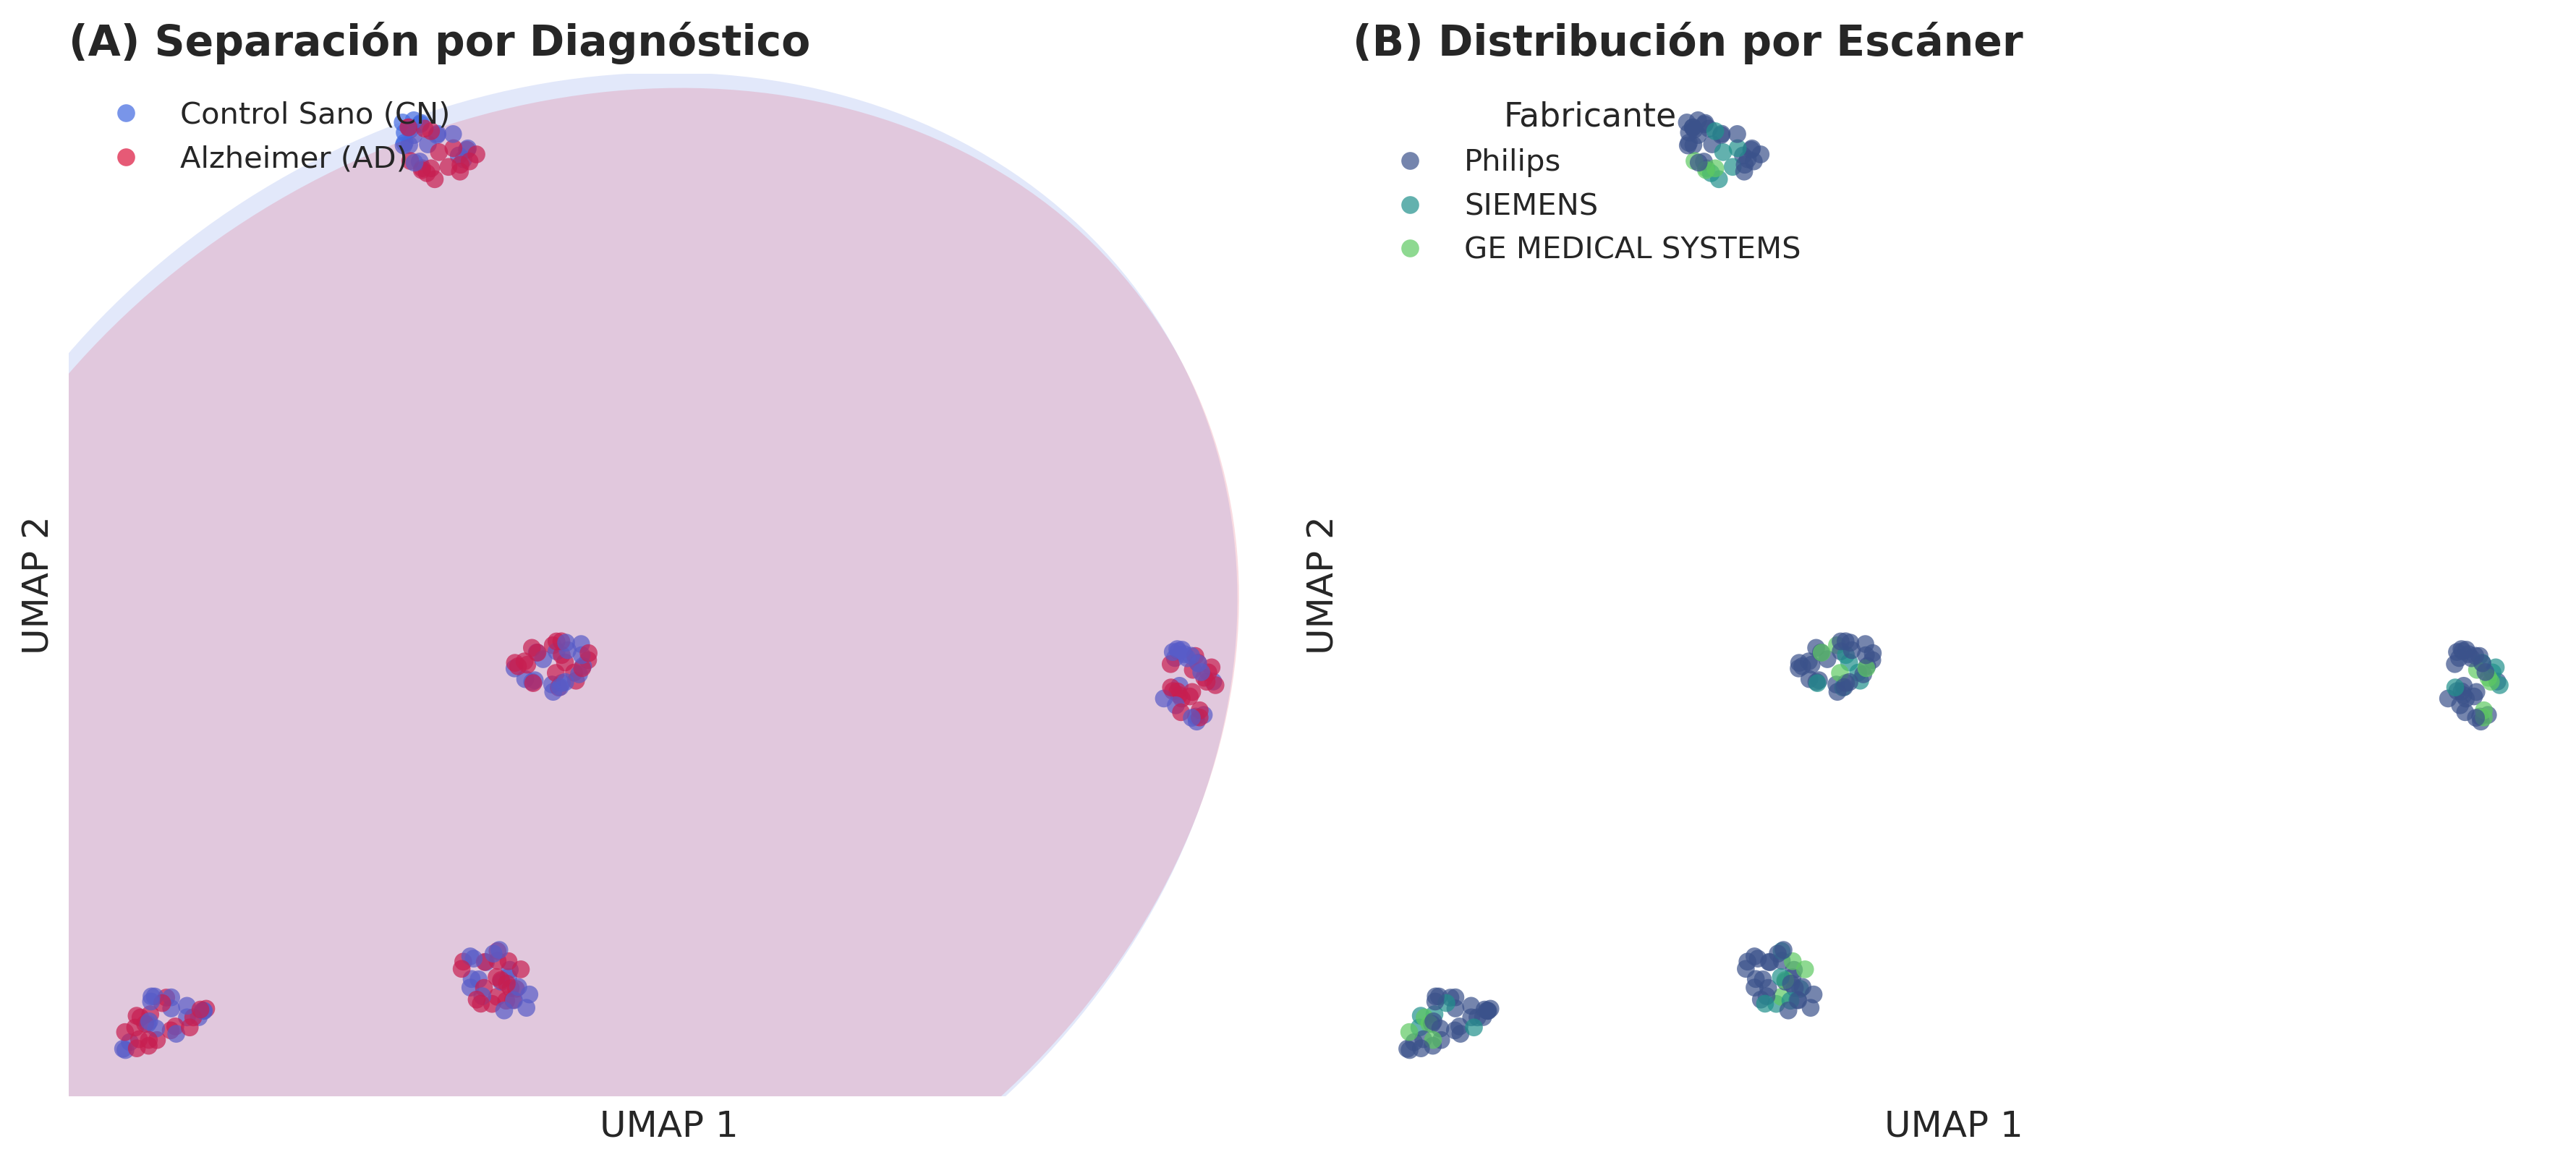

📄 Figura UMAP global de alta calidad guardada en: resultados31/publication_figures/fig3_umap_global_nature_style.pdf


In [7]:
if 'latent_full' in locals():
    # Ejecutar UMAP sobre el conjunto completo de datos de test
    embedding = umap_embedding(latent_full, n_neighbors=25, min_dist=0.05, metric='cosine')
    
    # Crear un DataFrame para facilitar el ploteo con Seaborn
    plot_df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
    plot_df['Diagnóstico'] = np.where(labels_full == 0, 'Control Sano (CN)', 'Alzheimer (AD)')
    plot_df['Escáner'] = scanners_full

    # --- Crear la figura con dos paneles ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
    
    # Panel (A): Separación por Diagnóstico
    sns.scatterplot(
        data=plot_df, x='UMAP 1', y='UMAP 2', hue='Diagnóstico',
        palette={'Control Sano (CN)': 'royalblue', 'Alzheimer (AD)': 'crimson'},
        edgecolor='none', s=35, alpha=0.7, ax=ax1
    )
    # Añadir elipses de confianza del 95%
    for cls, color in [('Control Sano (CN)', 'royalblue'), ('Alzheimer (AD)', 'crimson')]:
        ix = plot_df['Diagnóstico'] == cls
        confidence_ellipse(ax1, plot_df.loc[ix, 'UMAP 1'], plot_df.loc[ix, 'UMAP 2'],
                           facecolor=color, alpha=0.15, edgecolor='none')
    ax1.set_title("(A) Separación por Diagnóstico", loc='left', weight='bold')
    ax1.legend(title="", frameon=False, loc='upper left')

    # Panel (B): Distribución por Fabricante de Escáner
    sns.scatterplot(
        data=plot_df, x='UMAP 1', y='UMAP 2', hue='Escáner',
        palette='viridis', edgecolor='none', s=35, alpha=0.7, ax=ax2
    )
    ax2.set_title("(B) Distribución por Escáner", loc='left', weight='bold')
    ax2.legend(title="Fabricante", frameon=False, loc='upper left')
    
    # Limpieza final de ejes
    for ax in (ax1, ax2):
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)
    
    plt.tight_layout()
    fig_path = OUTPUT_FIG_DIR / "fig3_umap_global_nature_style.pdf"
    fig.savefig(fig_path, dpi=300)
    fig.savefig(fig_path.with_suffix(".png"), dpi=300, bbox_inches='tight') # También PNG
    plt.show()
    print(f"📄 Figura UMAP global de alta calidad guardada en: {fig_path}")

In [1]:
# # Notebook de Análisis y Figuras para Publicación
#
# Este cuaderno carga los resultados del pipeline final (ejecución en `./resultados/28`),
# procesa las métricas y genera un conjunto de tablas y figuras con calidad de publicación,
# siguiendo las mejores prácticas para revistas de alto impacto como Nature.
#
# Secciones:
# 1. Configuración e Imports
# 2. Tabla 1: Resumen de Rendimiento de Clasificadores
# 3. Figura 1: Curvas de Entrenamiento del VAE
# 4. Figura 2: Rendimiento Comparativo de Clasificadores (AUC, ROC, PR)
# 5. Figura 3: Análisis del Espacio Latente (UMAP)
# 6. Figura 4: Interpretabilidad del Modelo (SHAP)

# ## 1. Configuración, Imports y Carga de Datos
import joblib
import json
import glob
import re
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import torch
from pathlib import Path


# --- Importaciones de tu código (asegúrate de que los .py estén accesibles) ---
# Si da error, descomenta y ajusta la siguiente línea:
import sys
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae3 import ConvolutionalVAE
from serentipia15 import apply_normalization_params, load_data

# --- Estilo de Figuras para Publicación (estilo Nature) ---
plt.rc("font", family="serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# --- Rutas a los Artefactos del Experimento ---
RESULTS_DIR = Path("/home/diego/Escritorio/limpio/resultados/28")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/"
                          "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_"
                          "AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_"
                          "ROIreorderedYeo17_ParallelTuned/"
                          "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_"
                          "NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_"
                          "Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_"
                          "ParallelTuned.npz")
METADATA_CSV       = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

try:
    CSV_PATH = glob.glob(f"{RESULTS_DIR}/all_folds_metrics_MULTI_*.csv")[0]
    SUFFIX_RE = re.compile(r"all_folds_metrics_MULTI_(.+)\.csv")
    SUFFIX = SUFFIX_RE.search(CSV_PATH).group(1)
    
    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"
    PRED_PATH = RESULTS_DIR / f"all_folds_clf_predictions_MULTI_{SUFFIX}.joblib"
    
    print(f"✅ Archivos encontrados para el experimento:\n   {SUFFIX}")

    # --- Carga de Datos ---
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)
    predictions = joblib.load(PRED_PATH)
    
    # Determinar el mejor clasificador basado en la métrica objetivo
    scoring_metric = metrics_df.columns[metrics_df.columns.str.contains("auc_bal", case=False)][0]
    best_clf_name = metrics_df.groupby('classifier')[scoring_metric].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en '{scoring_metric}')")

except IndexError:
    print(f"❌ ERROR: No se encontraron los archivos de resultados en '{RESULTS_DIR}'. Asegúrate de que la ruta es correcta y el pipeline ha finalizado.")
    metrics_df, histories, predictions, best_clf_name = None, None, None, None


✅ Archivos encontrados para el experimento:
   xgb_vaeconvtranspose4l_ld256_beta1.1_normzscore_offdiag_ch4sel_intFChalf_drop0.25_ln1_outer5x1_scoreauc_bal07
🏆 Mejor clasificador identificado: 'gb' (basado en 'auc_bal07')


In [2]:


# ## 2. Tabla 1: Resumen de Rendimiento de Clasificadores

if metrics_df is not None:
    # Seleccionamos las métricas más relevantes para el paper
    key_metrics = {
        scoring_metric: 'Score Compuesto (AUC*0.7 + Bal.Acc*0.3)',
        'auc': 'AUC-ROC',
        'bal_acc_def': 'Balanced Accuracy',
        'sens_def': 'Sensibilidad (Recall)',
        'spec_def': 'Especificidad',
        'pr_auc': 'AUC-PR'
    }
    
    df_summary = metrics_df[metrics_df['classifier'] == best_clf_name][list(key_metrics.keys())]
    
    summary_stats = df_summary.agg(['mean', 'std']).T
    summary_stats.index = summary_stats.index.map(key_metrics)
    summary_stats['Performance'] = summary_stats.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)
    
    table1 = summary_stats[['Performance']]
    table1.index.name = 'Métrica de Evaluación'
    
    print("\n--- Tabla 1: Rendimiento del Modelo Óptimo (LightGBM) ---")
    display(table1)
    
    # Guardar en formato LaTeX
    table1.to_latex(OUTPUT_FIG_DIR / "table1_performance_summary.tex")
    print(f"📄 Tabla guardada en: {OUTPUT_FIG_DIR / 'table1_performance_summary.tex'}")


--- Tabla 1: Rendimiento del Modelo Óptimo (LightGBM) ---


,Performance
Métrica de Evaluación,
Score Compuesto (AUC*0.7 + Bal.Acc*0.3),0.827 ± 0.064
AUC-ROC,0.850 ± 0.068
Balanced Accuracy,0.774 ± 0.068
Sensibilidad (Recall),0.684 ± 0.098
Especificidad,0.864 ± 0.104
AUC-PR,0.886 ± 0.051


📄 Tabla guardada en: /home/diego/Escritorio/limpio/resultados/28/publication_figures/table1_performance_summary.tex


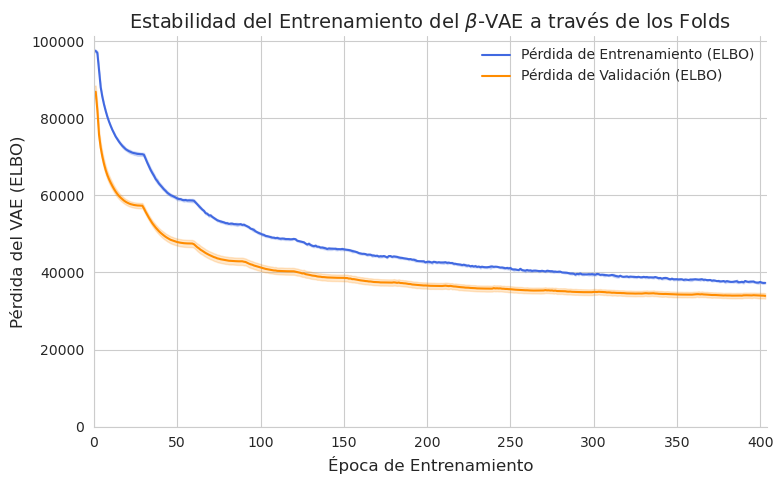

📄 Figura guardada en: /home/diego/Escritorio/limpio/resultados/28/publication_figures/fig1_vae_training_curves.pdf


In [3]:


# ## 3. Figura 1: Curvas de Entrenamiento del VAE (Estabilidad del Aprendizaje)

if histories is not None:
    # Truncar historiales a la longitud mínima para un promediado robusto
    min_len = min(len(h['train_loss']) for h in histories if h)
    
    train_loss = np.array([h['train_loss'][:min_len] for h in histories if h])
    val_loss = np.array([h['val_loss'][:min_len] for h in histories if h])
    
    mean_train, std_train = train_loss.mean(axis=0), train_loss.std(axis=0)
    mean_val, std_val = val_loss.mean(axis=0), val_loss.std(axis=0)
    
    epochs = np.arange(min_len)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(epochs, mean_train, color='royalblue', label='Pérdida de Entrenamiento (ELBO)')
    ax.fill_between(epochs, mean_train - std_train, mean_train + std_train, color='royalblue', alpha=0.2)
    
    ax.plot(epochs, mean_val, color='darkorange', label='Pérdida de Validación (ELBO)')
    ax.fill_between(epochs, mean_val - std_val, mean_val + std_val, color='darkorange', alpha=0.2)
    
    ax.set_xlabel("Época de Entrenamiento")
    ax.set_ylabel("Pérdida del VAE (ELBO)")
    ax.set_title("Estabilidad del Entrenamiento del $\\beta$-VAE a través de los Folds")
    ax.legend(frameon=False)
    ax.set_xlim(0, min_len)
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "fig1_vae_training_curves.pdf", dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {OUTPUT_FIG_DIR / 'fig1_vae_training_curves.pdf'}")

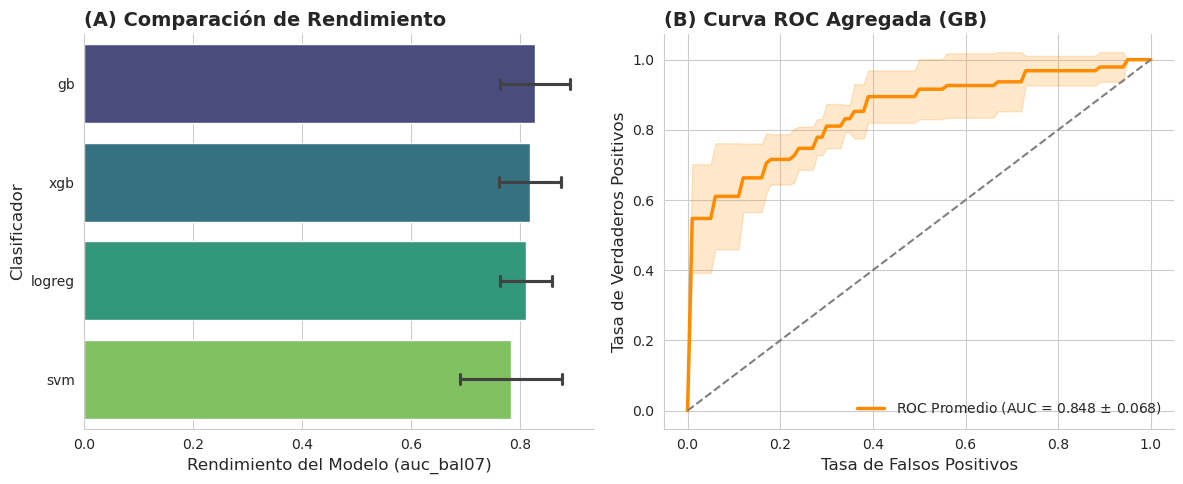

📄 Figura guardada en: /home/diego/Escritorio/limpio/resultados/28/publication_figures/fig2_classifier_performance.pdf


In [4]:
# ## 4. Figura 2: Rendimiento Comparativo de Clasificadores

if metrics_df is not None:
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2)

    # --- Panel A: Comparación de AUC ---
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        data=metrics_df, y='classifier', x=scoring_metric,
        order=metrics_df.groupby('classifier')[scoring_metric].mean().sort_values(ascending=False).index,
        palette='viridis', ax=ax1, errorbar='sd', capsize=0.1
    )
    ax1.set_xlabel(f"Rendimiento del Modelo ({scoring_metric})")
    ax1.set_ylabel("Clasificador")
    ax1.set_title("(A) Comparación de Rendimiento", loc='left', weight='bold')
    sns.despine(ax=ax1)

    # --- Panel B: Curva ROC Agregada del Mejor Modelo ---
    ax2 = fig.add_subplot(gs[0, 1])
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    best_clf_preds = [p for p in predictions if p['classifier'] == best_clf_name]
    
    for pred in best_clf_preds:
        fpr, tpr, _ = roc_curve(pred['y_test'], pred['proba_test'])
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    mean_auc = auc(base_fpr, mean_tprs)
    
    ax2.plot(base_fpr, mean_tprs, color='darkorange', lw=2.5, label=f'ROC Promedio (AUC = {mean_auc:.3f} $\\pm$ {metrics_df[metrics_df["classifier"]==best_clf_name]["auc"].std():.3f})')
    ax2.fill_between(base_fpr, mean_tprs - std_tprs, mean_tprs + std_tprs, color='darkorange', alpha=0.2)
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    ax2.set_xlabel("Tasa de Falsos Positivos")
    ax2.set_ylabel("Tasa de Verdaderos Positivos")
    ax2.set_title(f"(B) Curva ROC Agregada ({best_clf_name.upper()})", loc='left', weight='bold')
    ax2.legend(loc='lower right', frameon=False)
    sns.despine(ax=ax2)

    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "fig2_classifier_performance.pdf", dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {OUTPUT_FIG_DIR / 'fig2_classifier_performance.pdf'}")

[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
[INFO] Metadatos cargados. Forma: (434, 32)


✨ Figura guardada en /home/diego/Escritorio/limpio/resultados/28/fig3_per_fold_umap.pdf


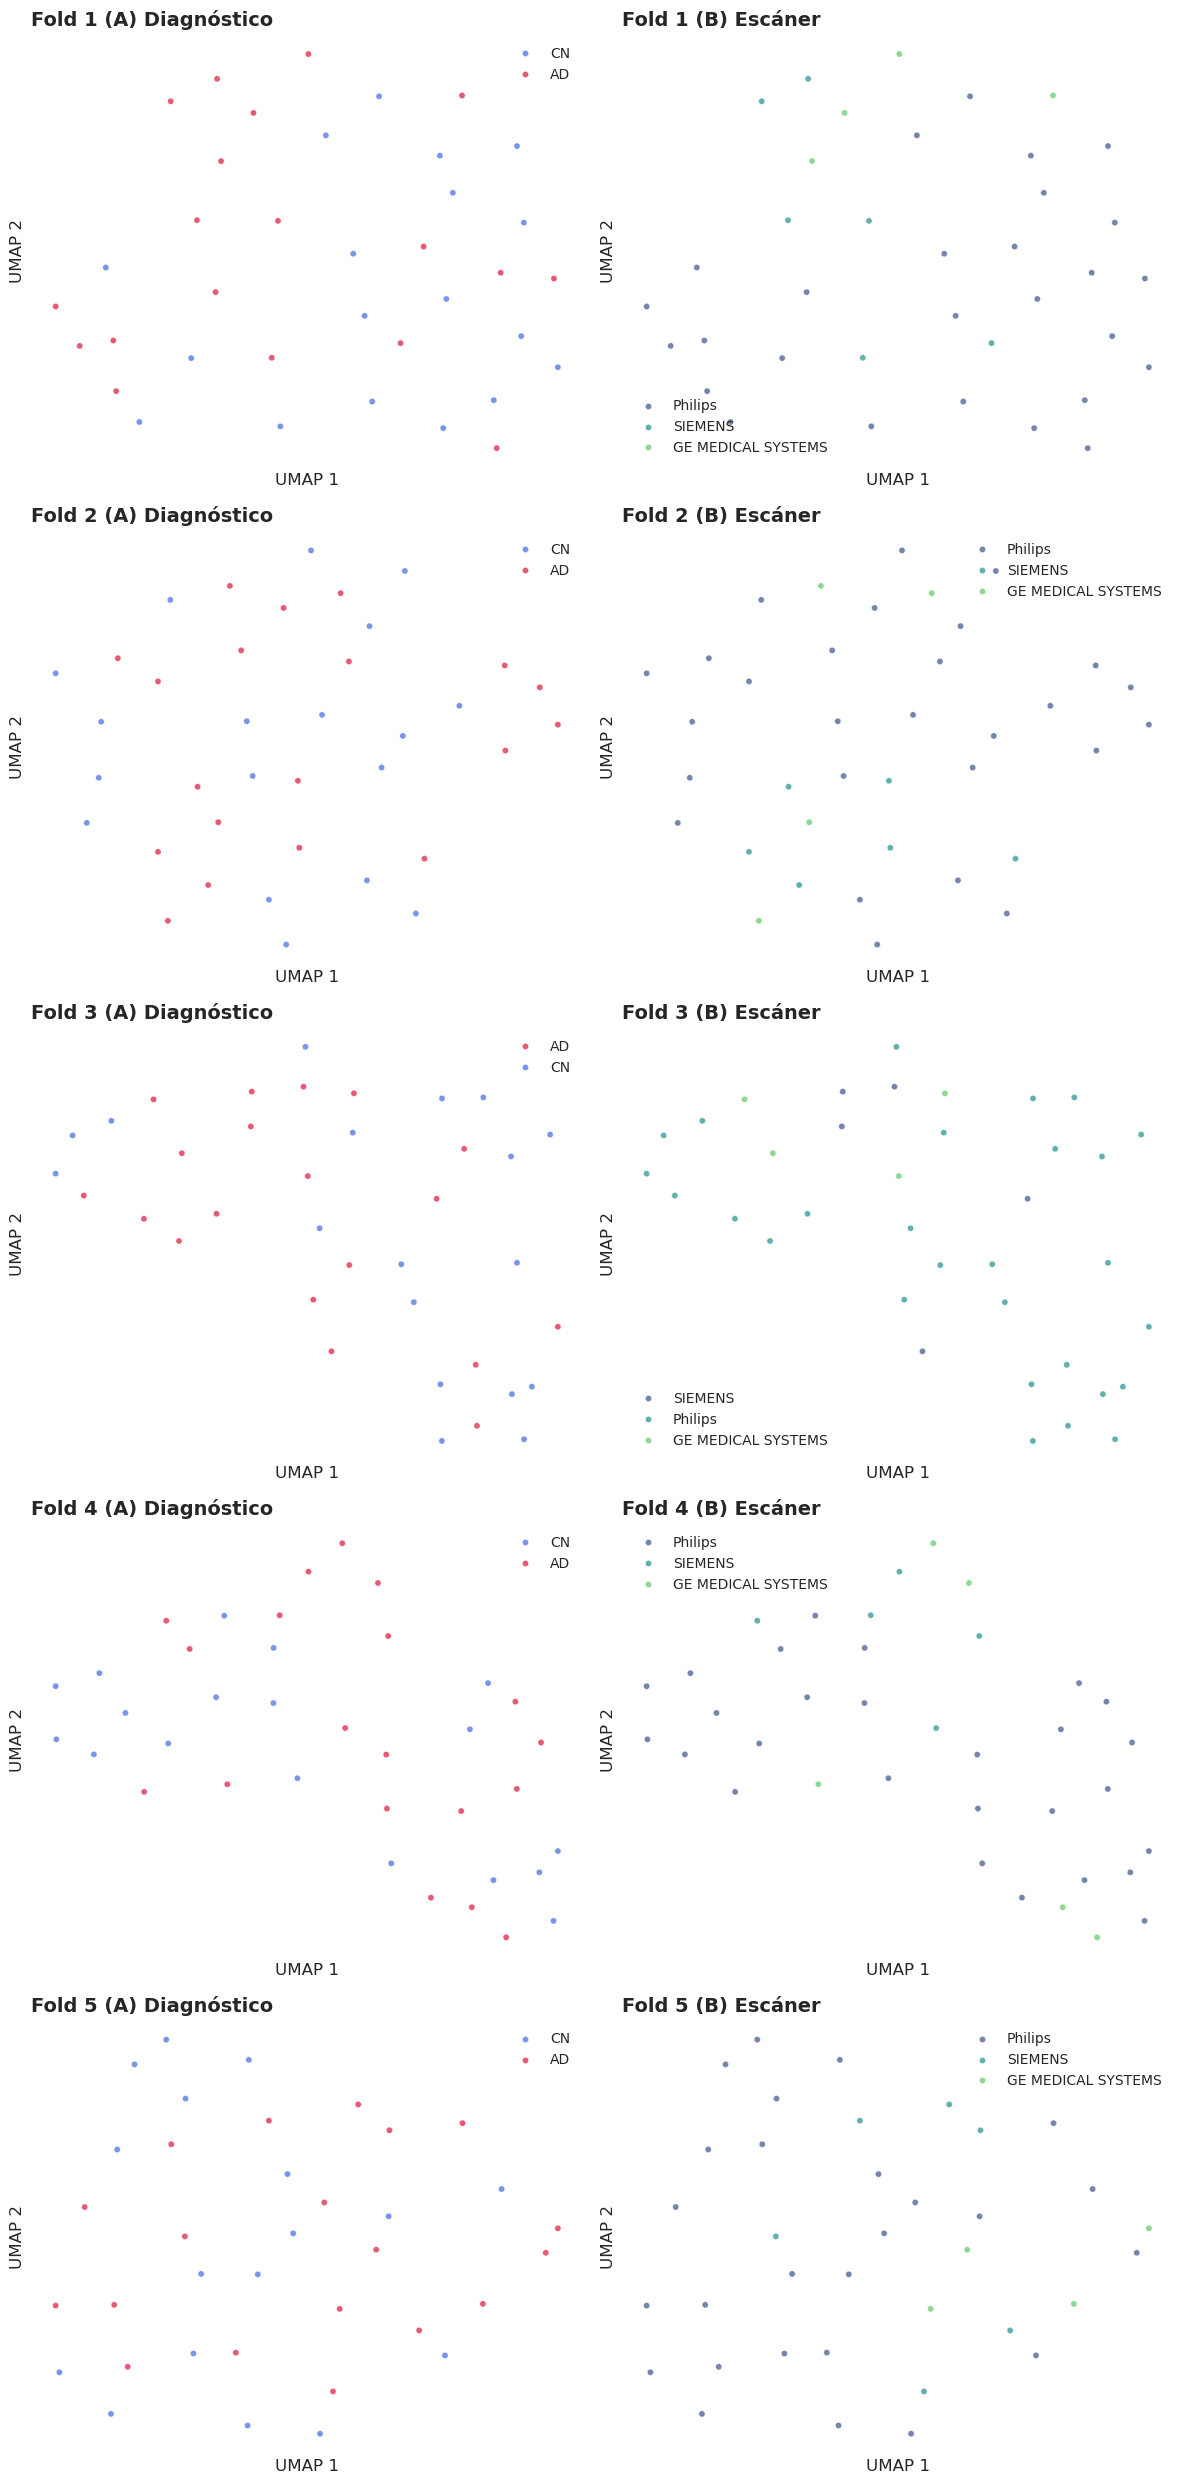

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from pathlib import Path
import joblib
import torch
from models.convolutional_vae3 import ConvolutionalVAE
from serentipia15 import load_data, apply_normalization_params

# Paths
RESULTS_DIR    = Path("/home/diego/Escritorio/limpio/resultados/28")
GLOBAL_TENSOR = Path(
    "/home/diego/Escritorio/limpio/"
    "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_"
    "AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_"
    "ROIreorderedYeo17_ParallelTuned/"
    "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_"
    "NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_"
    "Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_"
    "ParallelTuned.npz"
)
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv")
OUTPUT_FIG = RESULTS_DIR/"fig3_per_fold_umap.pdf"
# Carga datos
global_tensor, metadata_df = load_data(GLOBAL_TENSOR, METADATA_CSV)
cn_ad_df = metadata_df[metadata_df['ResearchGroup_Mapped'].isin(['CN','AD'])]

# Prepara figura 5 filas × 2 cols
fig, axes = plt.subplots(5, 2, figsize=(12, 25))
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1,
                    n_components=2, random_state=42,
                    metric='cosine')

for i in range(5):
    fold = i+1
    fold_dir = RESULTS_DIR/f"fold_{fold}"
    # 1) carga modelo y params
    vae = ConvolutionalVAE(
        input_channels=4,
        latent_dim=256,
        image_size=131,
        final_activation='linear',
        intermediate_fc_dim_config='half',   # antes intermediate_fc_dim
        dropout_rate=0.25,
        use_layernorm_fc=True,               # antes use_layernorm_vae_fc
        num_conv_layers_encoder=4,           # coeficientes que usaste al entrenar
        decoder_type='convtranspose',        # idem
        num_groups=16                        # si usaste GroupNorm en tu VAE
    )
    state = torch.load(fold_dir/f"vae_model_fold_{fold}.pt", map_location='cpu')
    vae.load_state_dict({k.replace('_orig_mod.',''):v for k,v in state.items()})
    vae.eval()
    norm_params = joblib.load(fold_dir/"vae_norm_params.joblib")

    # 2) extrae test idxs + metadatos
    test_ids = np.load(fold_dir/"subject_ids_test.npy")
    test_df  = cn_ad_df[cn_ad_df['SubjectID'].isin(test_ids)]
    idxs     = test_df['tensor_idx'].astype(int).values
    scanners = test_df['Manufacturer'].values
    labels   = test_df['ResearchGroup_Mapped'].values

    # 3) normaliza y proyecta VAE
    raw = global_tensor[idxs][:, [1,2,4,5],:,:]
    norm = apply_normalization_params(raw, norm_params)
    with torch.no_grad():
        _, mu, _, _ = vae(torch.from_numpy(norm).float())
    latent = mu.cpu().numpy()

    # 4) UMAP sólo para este fold
    emb = reducer.fit_transform(latent)
    df  = pd.DataFrame(emb, columns=("UMAP 1","UMAP 2"))
    df['Diagnóstico'] = labels
    df['Escáner']     = scanners

    # 5A) Diagnóstico
    ax_d = axes[i,0]
    sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2',
                    hue='Diagnóstico',
                    palette={'CN':'royalblue','AD':'crimson'},
                    s=20, alpha=0.7, ax=ax_d)
    ax_d.set_title(f"Fold {fold} (A) Diagnóstico", loc='left', weight='bold')
    ax_d.legend(title=None, frameon=False)
    ax_d.set_xticks([]); ax_d.set_yticks([])
    sns.despine(ax=ax_d, left=True, bottom=True)

    # 5B) Escáner
    ax_s = axes[i,1]
    sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2',
                    hue='Escáner', palette='viridis',
                    s=20, alpha=0.7, ax=ax_s)
    ax_s.set_title(f"Fold {fold} (B) Escáner", loc='left', weight='bold')
    ax_s.legend(title=None, frameon=False)
    ax_s.set_xticks([]); ax_s.set_yticks([])
    sns.despine(ax=ax_s, left=True, bottom=True)

plt.tight_layout()
fig.savefig(OUTPUT_FIG, dpi=300)
print(f"✨ Figura guardada en {OUTPUT_FIG}")


[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz



--- 🧠 Cargando tensor global y metadatos ---


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
[INFO] Metadatos cargados. Forma: (434, 32)


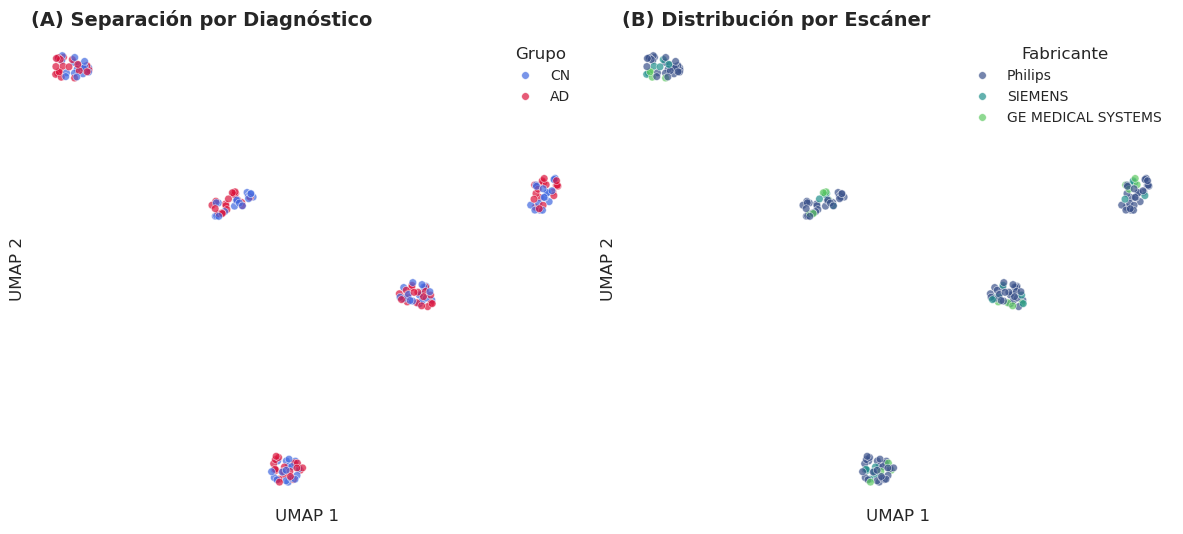

📄 Figura guardada en: /home/diego/Escritorio/limpio/resultados/28/publication_figures/fig3_latent_space_umap.pdf


In [6]:
# ## 5. Figura 3: Análisis del Espacio Latente (UMAP)

from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import torch
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
from models.convolutional_vae3 import ConvolutionalVAE
from serentipia15 import load_data, apply_normalization_params

# --- Rutas bien definidas como Path ---
RESULTS_DIR = Path("/home/diego/Escritorio/limpio/resultados/28")
GLOBAL_TENSOR_PATH = Path(
    "/home/diego/Escritorio/limpio/"
    "AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_"
    "AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_"
    "ROIreorderedYeo17_ParallelTuned/"
    "GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_"
    "NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_"
    "Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_"
    "ParallelTuned.npz"
)
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

try:
    print("\n--- 🧠 Cargando tensor global y metadatos ---")
    global_tensor, metadata_df = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    cn_ad_df = metadata_df[metadata_df['ResearchGroup_Mapped'].isin(['CN', 'AD'])].copy()
    
    all_latent_vectors = []
    all_labels = []
    all_scanners = []
    
    for fold_num in range(1, 6):
        fold_dir = RESULTS_DIR / f"fold_{fold_num}"

        # inicializas tu arquitectura
        vae_model = ConvolutionalVAE(
            input_channels=4,
            latent_dim=256,
            image_size=131,
            final_activation='linear',
            intermediate_fc_dim_config='half',   # antes intermediate_fc_dim
            dropout_rate=0.25,
            use_layernorm_fc=True,               # antes use_layernorm_vae_fc
            num_conv_layers_encoder=4,           # coeficientes que usaste al entrenar
            decoder_type='convtranspose',        # idem
            num_groups=16                        # si usaste GroupNorm en tu VAE
        )


        # cargamos el checkpoint y limpiamos keys si hace falta
        raw_state = torch.load(fold_dir / f"vae_model_fold_{fold_num}.pt", map_location='cpu')
        if any(k.startswith('_orig_mod.') for k in raw_state):
            state_dict = { k.replace('_orig_mod.', ''): v for k,v in raw_state.items() }
        else:
            state_dict = raw_state

        vae_model.load_state_dict(state_dict)          # o .load_state_dict(state_dict, strict=False)
        vae_model.eval()
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
        
        # 2) Sujetos de test
        test_ids = np.load(fold_dir / "subject_ids_test.npy")
        test_df = cn_ad_df[cn_ad_df['SubjectID'].isin(test_ids)]
        
        # 3) Extraer y normalizar tensores
        idxs = test_df['tensor_idx'].astype(int).values
        channels = [1, 2, 4, 5]
        raw = global_tensor[idxs][:, channels, :, :]
        norm = apply_normalization_params(raw, norm_params)
        
        # 4) Proyección VAE
        with torch.no_grad():
            _, mu, _, _ = vae_model(torch.from_numpy(norm).float())
        all_latent_vectors.append(mu.cpu().numpy())
        all_labels.append(test_df['ResearchGroup_Mapped'].values)
        all_scanners.append(test_df['Manufacturer'].values)
    
    # Concatenar todo
    latent_full   = np.vstack(all_latent_vectors)
    labels_full   = np.concatenate(all_labels)
    scanners_full = np.concatenate(all_scanners)
    
    # --- UMAP ---
    reducer   = umap.UMAP(n_neighbors=20, min_dist=0.1,
                         n_components=2, random_state=42,
                         metric='cosine')
    embedding = reducer.fit_transform(latent_full)
    
    plot_df = pd.DataFrame(embedding, columns=('UMAP 1', 'UMAP 2'))
    plot_df['Diagnóstico'] = labels_full
    plot_df['Escáner']      = scanners_full
    
    # --- Plot final ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))
    sns.scatterplot(data=plot_df, x='UMAP 1', y='UMAP 2',
                    hue='Diagnóstico',
                    palette={'CN':'royalblue','AD':'crimson'},
                    s=30, alpha=0.7, ax=ax1)
    ax1.set_title("(A) Separación por Diagnóstico", loc='left', weight='bold')
    ax1.legend(title="Grupo", frameon=False)
    
    sns.scatterplot(data=plot_df, x='UMAP 1', y='UMAP 2',
                    hue='Escáner', palette='viridis',
                    s=30, alpha=0.7, ax=ax2)
    ax2.set_title("(B) Distribución por Escáner", loc='left', weight='bold')
    ax2.legend(title="Fabricante", frameon=False)
    
    for ax in (ax1, ax2):
        ax.set_xticks([]); ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_FIG_DIR / "fig3_latent_space_umap.pdf", dpi=300)
    plt.show()
    print(f"📄 Figura guardada en: {OUTPUT_FIG_DIR/'fig3_latent_space_umap.pdf'}")
    
except Exception as e:
    print(f"⚠️ No se pudo generar la visualización UMAP. Error: {e}")


In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
import os

RESULTS_DIR = Path("/ruta/a/tu/resultados/28")

for k in range(1,6):
    fold_dir = RESULTS_DIR / f"fold_{k}"
    print(f"\nFold {k}:")
    print("  Archivos .npy:", list(fold_dir.glob("*.npy")))
    print("  Archivos .csv:", list(fold_dir.glob("*.csv")))



Fold 1:
  Archivos .npy: []
  Archivos .csv: []

Fold 2:
  Archivos .npy: []
  Archivos .csv: []

Fold 3:
  Archivos .npy: []
  Archivos .csv: []

Fold 4:
  Archivos .npy: []
  Archivos .csv: []

Fold 5:
  Archivos .npy: []
  Archivos .csv: []


In [8]:
# usa los vectores latentes ya serializados por fold_<k>/X_latent_*.npy
latent, labels = [], []
for k in range(1,6):
    path = f"{RESULTS_DIR}/fold_{k}/vae_latent_mu.npy"   # <-- si lo guardaste
    if os.path.exists(path):
        latent.append(np.load(path))
        meta  = pd.read_csv(f"{RESULTS_DIR}/fold_{k}/subjects_meta.csv")  # p.ej.
        labels.append(meta['label'].values)
latent = np.vstack(latent); labels = np.concatenate(labels)
embedding = UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(latent)
palette = {0:"#1f77b4", 1:"#d62728"}           # CN / AD
fig, ax = plt.subplots(figsize=(4,3.8))
for cls in np.unique(labels):
    ix = labels==cls; ax.scatter(embedding[ix,0], embedding[ix,1], 
                                 s=12, alpha=0.7, label="AD" if cls else "CN",
                                 c=palette[cls])
ax.axis('off'); ax.legend(frameon=False)
ax.set_title("Latent UMAP")
plt.tight_layout(); plt.savefig("fig_umap.png", dpi=600)


ValueError: need at least one array to concatenate

In [ ]:
import joblib, json, glob, re, os, itertools, warnings, pickle
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from umap import UMAP
plt.style.use('seaborn-v0_8-paper')
warnings.filterwarnings('ignore')

RESULTS_DIR = "/home/diego/Escritorio/limpio/resultados/28"   # <-- ajusta
SUFFIX_RE = re.compile(r"all_folds_metrics_MULTI_(.+)\.csv")
CSV_PATH  = glob.glob(f"{RESULTS_DIR}/all_folds_metrics_MULTI_*.csv")[0]
SUFFIX    = SUFFIX_RE.search(CSV_PATH).group(1)
HIST_PATH = f"{RESULTS_DIR}/all_folds_vae_training_history_{SUFFIX}.joblib"
PRED_PATH = f"{RESULTS_DIR}/all_folds_clf_predictions_MULTI_{SUFFIX}.joblib"
print("🗂  Using suffix:", SUFFIX)


🗂  Using suffix: xgb_vaeconvtranspose4l_ld256_beta1.1_normzscore_offdiag_ch4sel_intFChalf_drop0.25_ln1_outer5x1_scoreauc_bal07


In [ ]:
import pandas as pd

# 1) Lee tus métricas y quita las columnas que no necesitas
metrics = pd.read_csv(CSV_PATH)
df = metrics.drop(columns=['fold','best_params'])

# 2) Agrupa por clasificador y calcula mean y std
grouped = df.groupby('classifier').agg(['mean','std']).round(3)

# 3) Separa mean y std en dos DataFrames “anchos”
means = grouped.xs('mean', axis=1, level=1)
stds  = grouped.xs('std',  axis=1, level=1)

# 4) Junta en un único DataFrame con “mean ± std”
table1 = means.astype(str) + ' ± ' + stds.astype(str)
table1.index.name = 'Metric'

# 5) Muestra o exporta a LaTeX
display(table1)
# si quieres exportar a LaTeX:
# print(table1.to_latex())
           # ➜ cópialo a LaTeX con `.to_latex()`



,auc,pr_auc,optimal_threshold,acc_def,bal_acc_def,sens_def,spec_def,f1_def,acc_opt,bal_acc_opt,sens_opt,spec_opt,f1_opt,auc_bal07
Metric,,,,,,,,,,,,,,
gb,0.85 ± 0.068,0.886 ± 0.051,0.472 ± 0.044,0.772 ± 0.068,0.774 ± 0.068,0.684 ± 0.098,0.864 ± 0.104,0.754 ± 0.079,0.766 ± 0.056,0.767 ± 0.057,0.726 ± 0.069,0.808 ± 0.105,0.763 ± 0.056,0.827 ± 0.064
logreg,0.836 ± 0.049,0.874 ± 0.041,0.516 ± 0.064,0.75 ± 0.051,0.751 ± 0.052,0.716 ± 0.047,0.787 ± 0.071,0.748 ± 0.049,0.761 ± 0.04,0.762 ± 0.042,0.747 ± 0.044,0.776 ± 0.103,0.764 ± 0.03,0.811 ± 0.048
svm,0.811 ± 0.094,0.823 ± 0.103,0.535 ± 0.029,0.717 ± 0.095,0.718 ± 0.094,0.684 ± 0.139,0.752 ± 0.07,0.71 ± 0.106,0.717 ± 0.116,0.72 ± 0.114,0.611 ± 0.161,0.83 ± 0.093,0.685 ± 0.132,0.783 ± 0.094
xgb,0.85 ± 0.055,0.889 ± 0.038,0.543 ± 0.134,0.744 ± 0.075,0.747 ± 0.076,0.653 ± 0.08,0.841 ± 0.128,0.725 ± 0.077,0.728 ± 0.041,0.73 ± 0.04,0.663 ± 0.147,0.797 ± 0.136,0.71 ± 0.062,0.819 ± 0.058


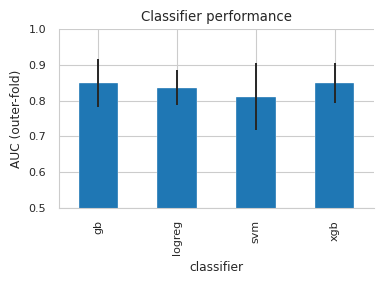

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
auc_means = metrics.pivot(index='fold', columns='classifier', values='auc').mean()
auc_stds  = metrics.pivot(index='fold', columns='classifier', values='auc').std()
auc_means.plot.bar(ax=ax, yerr=auc_stds, capsize=4)
ax.set_ylabel("AUC (outer-fold)")
ax.set_ylim(0.5,1)
ax.set_title("Classifier performance")
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.savefig("fig_auc_bar.png", dpi=600)


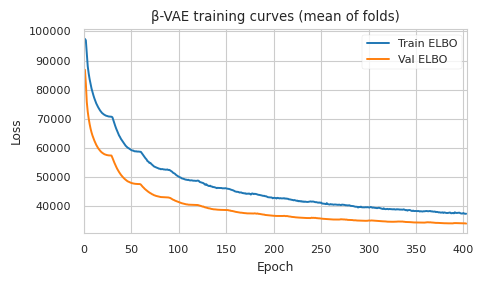

In [ ]:
histories = joblib.load(HIST_PATH)
# suponiendo histories = [h_fold1, h_fold2, ..., h_fold5]
min_epochs = min(len(h['train_loss']) for h in histories)

# apila fijo (folds×min_epochs)
train_arr = np.array([h['train_loss'][:min_epochs] for h in histories])
val_arr   = np.array([h['val_loss'][:min_epochs]   for h in histories])

mean_train = train_arr.mean(axis=0)
mean_val   = val_arr.mean(axis=0)

#mean_train = np.nanmean([h['train_loss'] for h in histories], axis=0)
#mean_val   = np.nanmean([h['val_loss']   for h in histories], axis=0)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(mean_train, label='Train ELBO')
ax.plot(mean_val,   label='Val ELBO')
ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.legend(); ax.set_title("β-VAE training curves (mean of folds)")
ax.set_xlim(0, len(mean_train))
plt.tight_layout(); plt.savefig("fig_vae_loss.png", dpi=600)


In [ ]:
from sklearn.metrics import roc_auc_score

# 1) Calcula la AUC para cada predicción y muéstralas
aucs = []
for d in preds:
    auc_fold = roc_auc_score(d['y_test'], d['proba_test'])
    aucs.append(auc_fold)
    print(f"Fold {d['fold']:d} ({d['classifier']}): AUC = {auc_fold:.3f}")

# 2) Selecciona el mejor diccionario según esa AUC calculada
best_idx = np.argmax(aucs)
best     = preds[best_idx]
best_auc = aucs[best_idx]
print(f"\nMejor fold → Fold {best['fold']} ({best['classifier']}) con AUC = {best_auc:.3f}")

# 3) Genera curvas ROC y PR a partir de ese ‘best’
y_true = best['y_test']
proba  = best['proba_test']

fpr, tpr, _ = roc_curve(y_true, proba)
prec, rec, _ = precision_recall_curve(y_true, proba)
pr_auc = average_precision_score(y_true, proba)

# ROC
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {best_auc:.2f})")
ax.plot([0,1],[0,1],'--', color='grey')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title(f"ROC – {best['classifier'].upper()}")
ax.legend()
plt.tight_layout()
plt.savefig("fig_roc.png", dpi=600)

# PR
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(rec, prec, lw=2, label=f"PR (AUC = {pr_auc:.2f})")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(f"Precision-Recall – {best['classifier'].upper()}")
ax.legend()
plt.tight_layout()
plt.savefig("fig_pr.png", dpi=600)


NameError: name 'preds' is not defined

In [ ]:
# usa los vectores latentes ya serializados por fold_<k>/X_latent_*.npy
latent, labels = [], []
for k in range(1,6):
    path = f"{RESULTS_DIR}/fold_{k}/vae_latent_mu.npy"   # <-- si lo guardaste
    if os.path.exists(path):
        latent.append(np.load(path))
        meta  = pd.read_csv(f"{RESULTS_DIR}/fold_{k}/subjects_meta.csv")  # p.ej.
        labels.append(meta['label'].values)
latent = np.vstack(latent); labels = np.concatenate(labels)
embedding = UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean').fit_transform(latent)
palette = {0:"#1f77b4", 1:"#d62728"}           # CN / AD
fig, ax = plt.subplots(figsize=(4,3.8))
for cls in np.unique(labels):
    ix = labels==cls; ax.scatter(embedding[ix,0], embedding[ix,1], 
                                 s=12, alpha=0.7, label="AD" if cls else "CN",
                                 c=palette[cls])
ax.axis('off'); ax.legend(frameon=False)
ax.set_title("Latent UMAP")
plt.tight_layout(); plt.savefig("fig_umap.png", dpi=600)



ValueError: need at least one array to concatenate